Dataset from https://google.github.io/cartoonset/download.html

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#importing required libraries
import os, time

import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython import display

import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam

In [3]:
# Convert seconds to HH:MM:SS.MI format
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [4]:
IMAGE_CHANNELS = 3
GENERATE_RESOLUTION_FACTOR = 3
GENERATE_SQUARE = 32 * GENERATE_RESOLUTION_FACTOR

# Preview image details
PREVIEW_ROWS, PREVIEW_COLS = 4, 7
PREVIEW_MARGIN = 16

# Source vector size to generate images
SEED_SIZE = 100

# Model configuration
DATA_PATH = '/content/drive/My Drive/Dataset/'
FOLDER_NAME = 'cartoonset10k'

EPOCHS = 100
BATCH_SIZE = 64
BUFFER_SIZE = 61000

print(f"Image details: {GENERATE_SQUARE}px")

Image details: 96px


In [5]:
#loading the dataset
training_binary_path = os.path.join(DATA_PATH, 
    f'training_data_{FOLDER_NAME}_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')
print("Binary file name: ", training_binary_path)

if not os.path.isfile(training_binary_path):
  start = time.time()
  training_data = []
  faces_path = os.path.join(DATA_PATH, FOLDER_NAME)
  faces_path_filenames = os.listdir(faces_path)
  for filename in tqdm(faces_path_filenames):
      path = os.path.join(faces_path,filename)
      # Convert RGBA to RGB format
      try:
        image = Image.open(path).convert("RGB").resize((GENERATE_SQUARE,
              GENERATE_SQUARE),Image.ANTIALIAS)
        training_data.append(np.asarray(image))
      except Exception as e:
        # print(f'[Error] image: {image}, exception: {e}')
        pass
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary file...")
  np.save(training_binary_path,training_data)
  stop = time.time()-start
  print (f'Image preprocess time: {hms_string(stop)}')
else:
  print("Loading previous training binary file...")
  load_data_start_time = time.time()
  training_data = np.load(training_binary_path)
  load_data_tat = time.time() - load_data_start_time
  print("Data load time: ", hms_string(load_data_tat))

Binary file name:  /content/drive/My Drive/Dataset/training_data_cartoonset10k_96_96.npy


100%|██████████| 10000/10000 [05:06<00:00, 32.65it/s]


Saving training image binary file...
Image preprocess time: 0:05:56.18


In [6]:
# Shuffle the dataset and create batches
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print("Length of total images: ", len(training_data))
print("Length of total batches: ", len(train_dataset))
print("Length of images in one batch: ", len(list(train_dataset.as_numpy_iterator())[0]))

Length of total images:  10000
Length of total batches:  157
Length of images in one batch:  64


In [7]:
#Generator
def build_generator(seed_size, channels):
  model = Sequential()

  model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Reshape((4, 4, 256)))
  
  model.add(Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())


  model.add(Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())


  model.add(Conv2DTranspose(64, (5, 5), strides=(3, 3), padding='same', use_bias=False, activation='tanh'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
  
  return model

In [8]:
#Discriminator
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.7))
    model.add(LeakyReLU(alpha=0.3))

    model.add(Dropout(0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.2))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.7))
    model.add(LeakyReLU(alpha=0.3))

    model.add(Dropout(0.2))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [9]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  
  fig = plt.figure(figsize=(15,15))
  plt.imshow(im)
  plt.show()
  im.save(filename)

Generated image shape:  (1, 96, 96, 3)


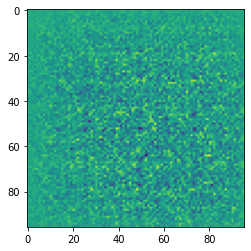

In [10]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)
print("Generated image shape: ", generated_image.shape)

plt.imshow(generated_image[0, :, :, 0])

In [11]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49995613]], shape=(1, 1), dtype=float32)


In [12]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#optimizers
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [13]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  # generate_and_save_images(generator, epochs, seed)
  return gen_loss,disc_loss

In [14]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [15]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, time={hms_string(epoch_elapsed)}')
    
    display.clear_output(wait=True)
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, time={hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  display.clear_output(wait=True)
  print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, time={hms_string(epoch_elapsed)}')
  save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

Epoch 100, gen loss=5.166158676147461,disc loss=0.3041575849056244, time=0:01:14.53


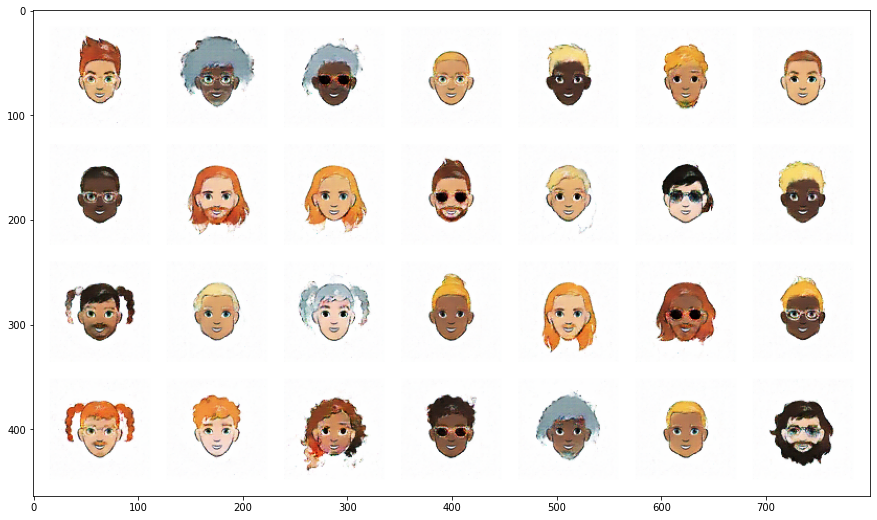

Training time: 2:06:48.31


In [16]:
train(train_dataset, EPOCHS)

In [17]:
name = f"face_generator_{EPOCHS}.h5"
generator.save(os.path.join(DATA_PATH, name))

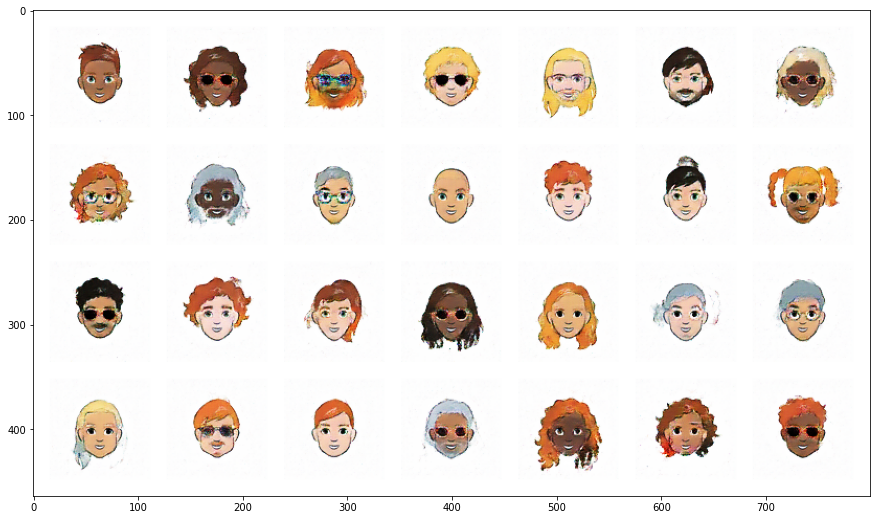

In [18]:
fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
save_images(100,fixed_seed)

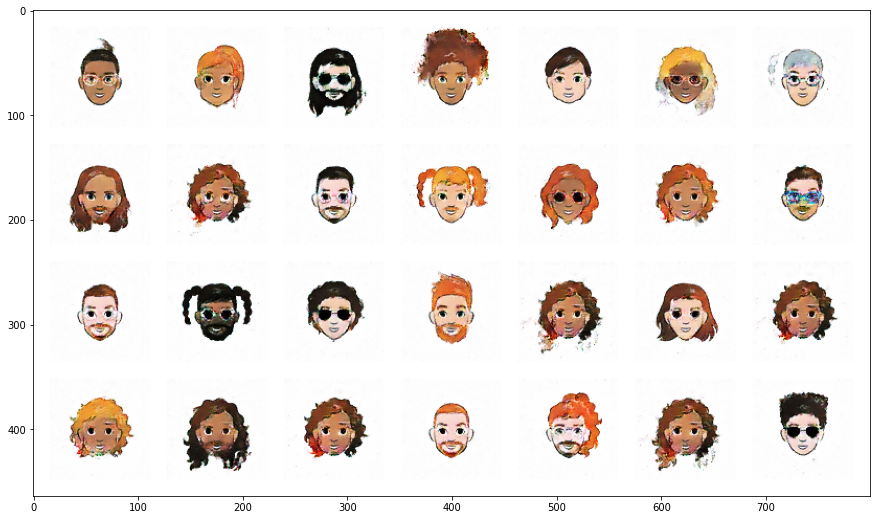

In [22]:
fixed_seed = np.random.normal(0, 2, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
save_images(1000,fixed_seed)